In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix

In [2]:
#import dataset
data = pd.read_csv("COMP30027_2021_Project2_datasets/recipe_train.csv")
testData = pd.read_csv("COMP30027_2021_Project2_datasets/recipe_test.csv")
data.head()

,name,n_steps,n_ingredients,steps,ingredients,duration_label
0,wi gal s chicken rice stove top dish made heal...,6,12,"['in saucepan , melt margarine and combine wit...","['margarine', 'olive oil', 'celery', 'onion', ...",2.0
1,irish pin oats,9,5,['melt 1 tbs butter in a small saucepan over m...,"['butter', 'pinhead oats', 'water', 'half-and-...",2.0
2,cheesy beef n biscuit casserole,15,10,"['brown ground beef , onion and green pepper',...","['ground beef', 'onion', 'green pepper', 'toma...",2.0
3,lemonade chicken oamc,10,8,"['brown chicken in oil', 'combine all ingredie...","['boneless skinless chicken', 'frozen lemonade...",2.0
4,graham and peanut butter bon bons,6,5,"['set almond bark aside', 'mix remaining ingre...","['graham cracker crumbs', 'crunchy peanut butt...",2.0


<BarContainer object of 3 artists>

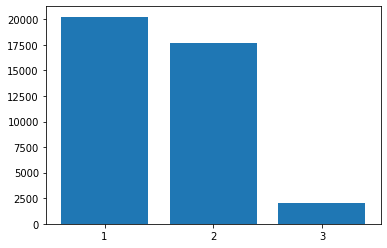

In [3]:
#visualise class label distribution
count = list(data['duration_label'].value_counts())
plt.bar(["1", "2", "3"], count)

<AxesSubplot:xlabel='duration_label', ylabel='n_ingredients'>

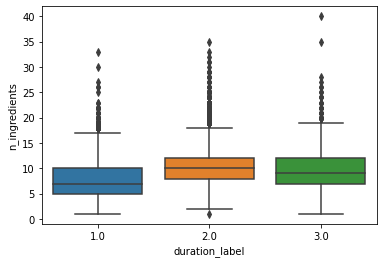

In [4]:
#relationship between duration label and number of ingredients
sns.boxplot(x='duration_label',y='n_ingredients',data=data)

<AxesSubplot:xlabel='duration_label', ylabel='n_steps'>

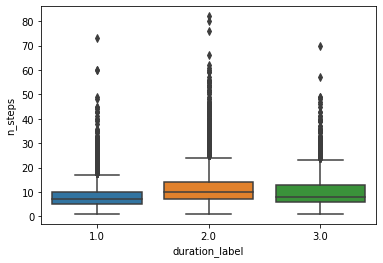

In [5]:
#relationship between duration label and number of steps
sns.boxplot(x='duration_label',y='n_steps',data=data)

In [6]:
#Data Preprocessing - "[aa, bb]" -> "aa, bb"
data['steps'] = data['steps'].apply(eval).apply(' '.join)
data['ingredients'] = data['ingredients'].apply(eval).apply(' '.join)
testData['steps'] = testData['steps'].apply(eval).apply(' '.join)
testData['ingredients'] = testData['ingredients'].apply(eval).apply(' '.join)

In [7]:
#countVectorizer - steps
vectorizer = CountVectorizer(stop_words="english").fit(data['steps'])
steps_vocab_cv = np.array(vectorizer.get_feature_names())
train_steps_cv = vectorizer.transform(data['steps'])

# cvectorizer = CountVectorizer(stop_words="english")
# train_steps_cv = cvectorizer.fit_transform(data['steps'])
# test_steps_cv = cvectorizer.fit_transform(testData['steps'])
train_steps_cv

<40000x17967 sparse matrix of type '<class 'numpy.int64'>'
	with 1737821 stored elements in Compressed Sparse Row format>

In [8]:
#TfidfVectorizer - steps
vectorizer = TfidfVectorizer(stop_words="english").fit(data['steps'])
steps_vocab_tf = np.array(vectorizer.get_feature_names())
train_steps_tfidf = vectorizer.transform(data['steps'])
test_steps_tfidf = vectorizer.transform(testData['steps'])

# tvectorizer = TfidfVectorizer(stop_words="english")
# train_steps_tfidf = tvectorizer.fit_transform(data['steps'])

train_steps_tfidf

<40000x17967 sparse matrix of type '<class 'numpy.float64'>'
	with 1737821 stored elements in Compressed Sparse Row format>

In [9]:
y_train = data['duration_label']

In [10]:
def write_to_csv(predicted):
    print("write to csv...")
    df = pd.DataFrame({'id': np.arange(1, 10001),
                   'duration_label': predicted})
    df.to_csv(r'result.csv')

In [11]:
#Multinomial Naive Bayes - countVectorizer
mnb = MultinomialNB()
mnb.fit(train_steps_cv, y_train)
scores_cv = cross_val_score(mnb, train_steps_cv, y_train, cv=20)
print(scores_cv)

[0.7105 0.721  0.7275 0.731  0.7185 0.726  0.7385 0.7195 0.7165 0.7275
 0.7335 0.751  0.73   0.7165 0.744  0.7065 0.7045 0.7315 0.725  0.7305]


In [12]:
#Multinomial Naive Bayes - tfidfVectorizer
mnb.fit(train_steps_cv, y_train)
scores_tf = cross_val_score(mnb, train_steps_tfidf, y_train, cv=20)
print(scores_tf)

[0.6915 0.693  0.7095 0.709  0.6865 0.7015 0.707  0.692  0.6805 0.69
 0.6945 0.732  0.7005 0.697  0.719  0.69   0.6885 0.708  0.701  0.714 ]


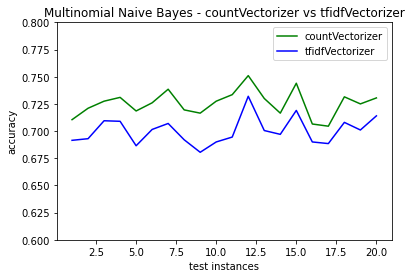

In [13]:
plt.plot(np.arange(1,21), scores_cv, '-g',label='countVectorizer');
plt.plot(np.arange(1, 21), scores_tf,'-b', label='tfidfVectorizer')
plt.ylim(0.6, 0.8);
plt.title("Multinomial Naive Bayes - countVectorizer vs tfidfVectorizer")
plt.xlabel("test instances")
plt.ylabel("accuracy");
plt.legend();

In [14]:
mnb2 = Pipeline([('kBest', SelectKBest(chi2, k=3500)), ('mnb', MultinomialNB())])
mnb2.fit(train_steps_tfidf, y_train)
scores_tf2 = cross_val_score(mnb2, train_steps_tfidf, y_train, cv=20)
# print(np.mean(scores_tf))

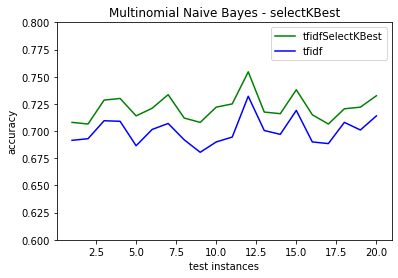

In [39]:
plt.plot(np.arange(1,21), scores_tf2, '-g',label='tfidfSelectKBest');
plt.plot(np.arange(1, 21), scores_tf,'-b', label='tfidf')
plt.ylim(0.6, 0.8);
plt.title("Multinomial Naive Bayes - selectKBest")
plt.xlabel("test instances")
plt.ylabel("accuracy");
plt.legend();

In [107]:
important_word = np.argsort(mnb.feature_log_prob_)[:,::-1][:,:20]
print(important_word)
for i in range(len(important_word)):
    print(steps_vocab_cv[important_word[i]])

[[ 1172 10054  7731 15265  2590  4278 10112 10136 13984 11832 10796 13544
   9812 11218  4007  2977  8281 11553  3491  8929]
 [10054  1172  7731 11218 10136 11038 15265  2590  1944  4278 10112 13544
  11832  2977  8929  1962 15502  3554  9812 10796]
 [ 1172  7943  4278  4442 11832 10054  7731 15265  9384 17374  2590 12072
  12118 10136 10112  3554 13626  9789 13027 13544]]
['add' 'minutes' 'heat' 'stir' 'bowl' 'cook' 'mix' 'mixture' 'serve'
 'place' 'oil' 'salt' 'medium' 'pan' 'combine' 'butter' 'ingredients'
 'pepper' 'cheese' 'large']
['minutes' 'add' 'heat' 'pan' 'mixture' 'oven' 'stir' 'bowl' 'bake' 'cook'
 'mix' 'salt' 'place' 'butter' 'large' 'baking' 'sugar' 'chicken' 'medium'
 'oil']
['add' 'hours' 'cook' 'cover' 'place' 'minutes' 'heat' 'stir' 'low'
 'water' 'bowl' 'pot' 'pour' 'mixture' 'mix' 'chicken' 'sauce' 'meat'
 'remove' 'salt']


In [17]:
kBest_tfidf = SelectKBest(chi2, k=5000).fit(train_steps_tfidf, y_train)
top30 = kBest_tfidf.scores_.argsort()[::-1][:30]
steps_vocab_tf[top30]

array(['crock', 'hours', 'cooker', 'slow', 'crockpot', 'roast', 'pot',
       'low', 'bake', 'oven', '350', '30', 'brisket', 'setting', '45',
       '40', 'dish', 'cake', 'baking', 'minutes', 'casserole', '35',
       'meat', '25', 'potatoes', 'degrees', 'cover', 'ribs', 'pan',
       'overnight'], dtype='<U30')

In [81]:
k_range = [5, 10, 20, 40, 80, 160, 240, 320, 400, 500]

# list of scores from k_range
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, train_steps_tfidf, y_train, cv=5, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
print(k_scores)

[0.694125, 0.71425, 0.7306250000000001, 0.735225, 0.7328250000000001, 0.7259, 0.7204999999999999, 0.712125, 0.7063, 0.6971499999999999]


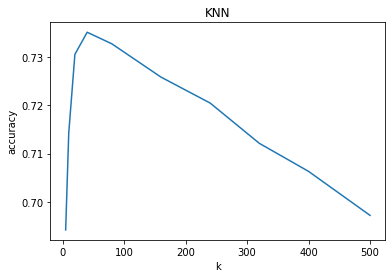

In [85]:
plt.plot(k_range, k_scores)
plt.title("KNN")
plt.xlabel("k")
plt.ylabel("accuracy");

In [18]:
#knn
neigh = KNeighborsClassifier(n_neighbors=40)
neigh.fit(train_steps_tfidf, y_train)
scores_knn = cross_val_score(neigh, train_steps_tfidf, y_train, cv=20)

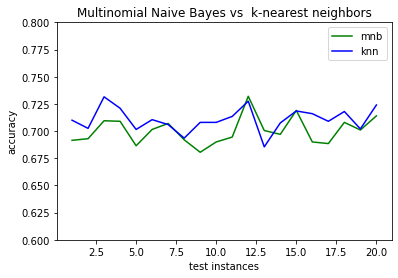

In [19]:
plt.plot(np.arange(1,21), scores_tf, '-g',label='mnb');
plt.plot(np.arange(1, 21), scores_knn,'-b', label='knn')
plt.ylim(0.6, 0.8);
plt.title("Multinomial Naive Bayes vs  k-nearest neighbors")
plt.xlabel("test instances")
plt.ylabel("accuracy");
plt.legend();

In [20]:
#Linear Support Vector Classification
svc = Pipeline([('kBest', SelectKBest(chi2, k=3500)), ('svc', LinearSVC())])
svc.fit(train_steps_tfidf, y_train)
scores_svc = cross_val_score(svc, train_steps_tfidf, y_train, cv=20)
predicted = svc.predict(test_steps_tfidf)
# print(np.mean(scores))

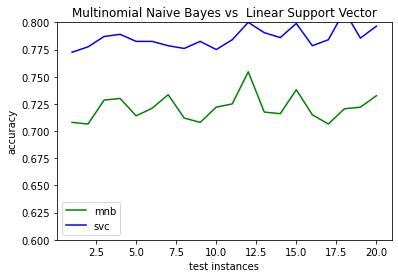

In [87]:
plt.plot(np.arange(1,21), scores_tf2, '-g',label='mnb');
plt.plot(np.arange(1, 21), scores_svc,'-b', label='svc')
plt.ylim(0.6, 0.8);
plt.title("Multinomial Naive Bayes vs  Linear Support Vector")
plt.xlabel("test instances")
plt.ylabel("accuracy");
plt.legend();

In [22]:
write_to_csv(predicted)

write to csv...


In [27]:
#confusion Matrix
y_pred = cross_val_predict(svc, train_steps_tfidf, y_train, cv=10)
conf_mat = confusion_matrix(y_train, y_pred)

In [28]:
conf_mat

array([[14170,  3431,   104],
       [ 4056, 16058,   132],
       [  388,   498,  1163]], dtype=int64)

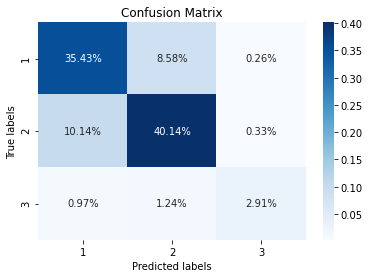

In [38]:
ax= plt.subplot()
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, ax=ax,
            fmt='.2%', cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1', '2','3']); ax.yaxis.set_ticklabels(['1', '2','3']);

In [58]:
print(top30)
dense = pd.DataFrame.sparse.from_spmatrix(train_steps_tfidf)
#print(dense.iloc[:, 4597])

[ 4597  7943  4286 14509  4603 13306 12072  9384  1944 11038   585   530
  2739 14007   729   686  5317  3058  1962 10054  3283   584  9789   434
 12083  5020  4442 13214 11218 11096]


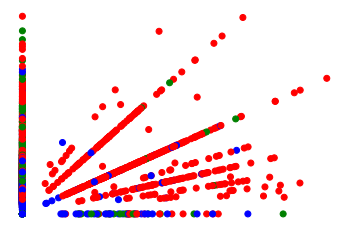

In [78]:
color = []
for c in y_train:
    if c == 1:
        color.append('green')
    elif c == 2:
        color.append("blue")
    else:
        color.append('red')

plt.scatter(dense.iloc[:, 4597], dense.iloc[:, 7943], c=color)

# Create the hyperplane
# w = svc2.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(1, 1)
# yy = a * xx - (svc2.intercept_[0]) / w[1]

# Plot the hyperplane
# plt.plot(xx, yy)
plt.axis("off"), plt.show();

In [90]:
svc2 = LinearSVC();
svc2.fit(train_steps_tfidf, y_train)

LinearSVC()

In [101]:
top20SVC = np.argsort(svc2.coef_)[:,::-1][:,:20]
print(top20SVC)
for i in range(len(top20SVC)):
    print(steps_vocab_cv[top20SVC[i]])

[[13879 13875  7834  4217 17517  5744  5802 13107 17776  8695 16639  4145
  17499 14120  5500 14922   580  2067  1212 12206]
 [  530   584   686   729  7941   434   789  7954 17018  1944   814 12593
    329  8227  6296   846 12258   585 16889  2524]
 [ 7943  4597 14509  4603  6017 11096 14568  2739  5027  4286 17489   435
    386  4442  3705  7004 10045   330 16602 17314]]
['seconds' 'sec' 'hiss' 'contact' 'whir' 'eggwash' 'em' 'residual' 'x1'
 'keeps' 'truly' 'confetti' 'whichever' 'shiitake' 'draft' 'splits' '345'
 'basted' 'adjusting' 'premade']
['30' '35' '40' '45' 'hour' '25' '50' 'hr' 'upto' 'bake' '55' 'quik' '20'
 'indirect' 'fenugreek' '60' 'pressure' '350' 'unique' 'book']
['hours' 'crock' 'slow' 'crockpot' 'everclear' 'overnight' 'smoker'
 'brisket' 'dehydrate' 'cooker' 'wheatberries' '250' '225' 'cover' 'churn'
 'garnishes' 'minumum' '200' 'trifle' 'walk']


In [108]:
df = pd.DataFrame({'seconds': dense.iloc[:, 13879], 
               '30': dense.iloc[:, 530],
               'hours':dense.iloc[:, 7943], 
                   'add': dense.iloc[:, 1172],
                   'minutes': dense.iloc[:, 10054],
               'label': y_train})

<AxesSubplot:xlabel='label', ylabel='seconds'>

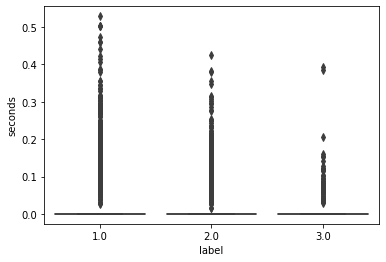

In [104]:
sns.boxplot(x='label',y='seconds',data=df)

<AxesSubplot:xlabel='label', ylabel='30'>

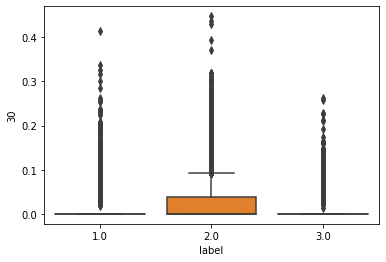

In [105]:
sns.boxplot(x='label',y='30',data=df)

<AxesSubplot:xlabel='label', ylabel='hours'>

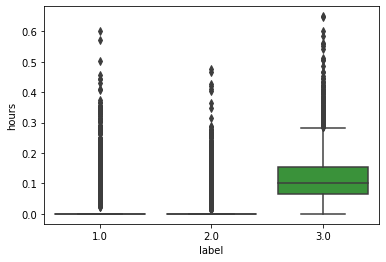

In [106]:
sns.boxplot(x='label',y='hours',data=df)

<AxesSubplot:xlabel='label', ylabel='add'>

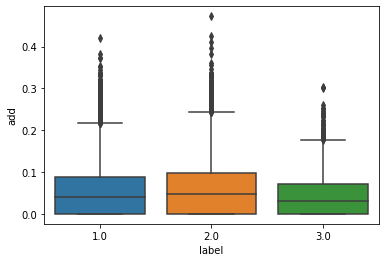

In [109]:
sns.boxplot(x='label',y='add',data=df)

<AxesSubplot:xlabel='label', ylabel='minutes'>

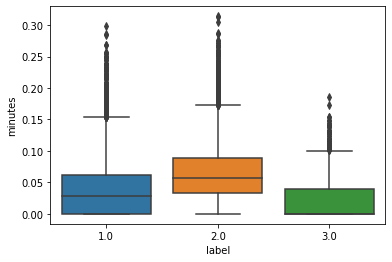

In [110]:
sns.boxplot(x='label',y='minutes',data=df)